# Importing Libraries

In [1]:
!pip install wget -q
!pip install gdown -q
!pip install opencv-python -q
!pip install imutils -q

In [2]:
import numpy as np

# from kaggle.api.kaggle_api_extended import KaggleApi

import cv2

import os

import wget

import gdown

import pandas as pd

import matplotlib.pyplot as plt

import math

from tqdm import tqdm

import glob

import shutil

import imutils

import random

import ast

import xml.etree.ElementTree as ET

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Download the working data

In [3]:
ROOT = os.getcwd()

# comment this line if you are using kaggle
# ROOT = os.path.dirname(ROOT)

utils_dir = os.path.join(ROOT, 'utils')

In [4]:
# Comment this cell line if you are running locally

os.makedirs(utils_dir, exist_ok=True)  # Create the data directory if it doesn't exist

# Google Drive folder ID
FOLDER_ID = "1nTsEHmKnQrjv6yLfp3FyzOqsFU9xhOc9"

# gdown syntax for downloading folders
gdown.download_folder(f"https://drive.google.com/drive/folders/{FOLDER_ID}", output=utils_dir)

folder_file_list = os.listdir(utils_dir)
print("Utils folder list: \n", folder_file_list)

Retrieving folder contents


Processing file 17LAbe_EM-5aLW1B50SHF_A35gus1wz1r utils.py


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=17LAbe_EM-5aLW1B50SHF_A35gus1wz1r
From (redirected): https://drive.google.com/uc?id=17LAbe_EM-5aLW1B50SHF_A35gus1wz1r&confirm=t&uuid=83853406-0115-4244-ad13-160f4c641f63
To: /kaggle/working/utils/utils.py
100%|██████████| 2.85k/2.85k [00:00<00:00, 2.93MB/s]

Utils folder list: 
 ['utils.py']



Download completed


# Importing util functions

In [5]:
from utils.utils import *

## display the functions inside the utils file

In [6]:

def display_functions(file_path):
    with open(file_path, "r") as f:
        file_contents = f.read()
    
    # Parse the file's contents using ast
    parsed_code = ast.parse(file_contents)
    
    # Loop through the parsed nodes and find functions
    for node in parsed_code.body:
        if isinstance(node, ast.FunctionDef):
            print(f"Function name: {node.name}")
            print(f"Arguments: {[arg.arg for arg in node.args.args]}")
            print(f"Line number: {node.lineno}\n")

# Replace it with the path to your .py file
file_path = utils_dir + "/utils.py"
display_functions(file_path)


Function name: show_images
Arguments: ['images', 'titles']
Line number: 30

Function name: show_3d_image
Arguments: ['img', 'title']
Line number: 50

Function name: show_3d_image_filtering_in_freq
Arguments: ['img', 'f']
Line number: 75

Function name: showHist
Arguments: ['img']
Line number: 87



# Preprocessing

In [7]:
# Paths for data set and its folder
# NOTE: the annotation directory contains the location of the plate in the image
# this will be implemented from scratch, and we will compare our results with the actual result of the dataset

# comment the following lines if you are using kaggle
#-------------------------------------------------------------
# dataset_dir = os.path.join(ROOT, 'data','car-plate-detection') 
# if not os.path.exists(dataset_dir):
#     # Authenticate
#     api = KaggleApi()
#     api.authenticate()
    
#     # Download the dataset
#     api.dataset_download_files('andrewmvd/car-plate-detection', path=dataset_dir, unzip=True)
#-------------------------------------------------------------

DATA_DIR = '/kaggle/input/car-plate-detection' # Kaggle
# DATA_DIR = dataset_dir # Local
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
ANNOTATIONS_DIR = os.path.join(DATA_DIR, 'annotations')
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 200

# sorts filenames alphabetically (lexicographically)
image_files = sorted(os.listdir(IMAGES_DIR))

In [8]:
# Function to load an image and its corresponding annotation
def load_image_and_annotation(image_name, 
                              image_dir, 
                              annotation_dir,
                              load_annotation = False):
    # 1- get image path 
    # 2- read image 
    # 3- convert to RGB for display
    # When using cv2.imread(), the image is loaded in BGR order, not RGB.
    # so we need to convert it to RGB to display it correctly
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    if not load_annotation: return image

    # get the file extension from the image path
    extension = image_path.split('.')[1]

    print(f'file extension: {extension}')

    # Load corresponding XML annotation
    annotation_path = os.path.join(annotation_dir, image_name.replace(f'.{extension}', '.xml'))
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Get bounding box coordinates from the XML for the plate location
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Draw the bounding box on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    return image

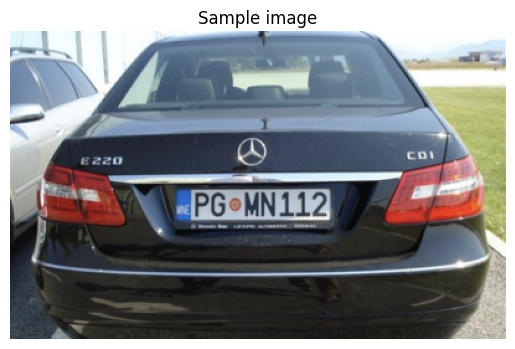

In [9]:
sample_image_name = image_files[1]
sample_image = load_image_and_annotation(sample_image_name, image_dir = IMAGES_DIR , annotation_dir = ANNOTATIONS_DIR)

show_images([sample_image],['Sample image'])

## Convert to GrayScale

In [10]:
def convert_to_gray(image):
    height, width, channels = image.shape
    gray_image = image
    if channels == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif channels == 4:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    else:
        print("Unkown color system the image will remain unchanged")

    return gray_image

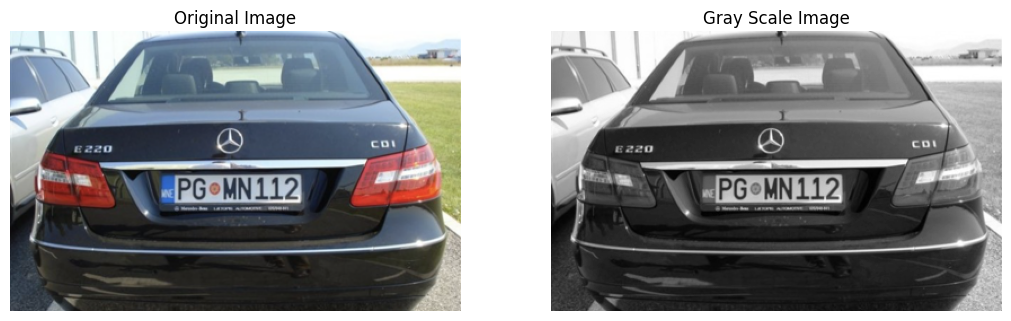

In [11]:
gray_image  = convert_to_gray(sample_image)

show_images([sample_image,gray_image],['Original Image' , 'Gray Scale Image'])

## Resize image

In [12]:
# The input image must be gray
# cv2.INTER_AREA is best for downscaling the image
def resize_with_aspect_ratio(gray_image, 
                             width = None, 
                             height = None, 
                             keep_aspect_ratio = False , 
                             interpolation = cv2.INTER_AREA):
    # Get the original width and height
    original_height,original_width = gray_image.shape
    # Set the original value to original dimensions

    if width is None and height is None: return gray_image 

    if width is None: width = original_width
    if height is None: height = original_height    

    if not keep_aspect_ratio: return cv2.resize(gray_image, (width, height), interpolation=interpolation)
        
    if width is not None:
        scaling_factor = width / original_width
    else:
        scaling_factor = height / original_height

    new_size = (int(original_width * scaling_factor), int(original_height * scaling_factor))
    
    resized_image = cv2.resize(gray_image, new_size, interpolation=interpolation)
    
    return resized_image    
    

### Get the average width and height of the dataset

In [13]:
total_width = 0
total_height = 0
num_images = len(image_files)

for image_file in  tqdm(image_files, desc="Processing images", unit=" image"):
    
    image_path = os.path.join(IMAGES_DIR, image_file)
    
    image = cv2.imread(image_path)
    
    if image is not None:
        height, width, _ = image.shape
        total_width += width
        total_height += height

# Calculate average width and height
average_width = total_width / num_images
average_height = total_height / num_images

print(f"Average Width: {average_width:.2f}")
print(f"Average Height: {average_height:.2f}")

Processing images: 100%|██████████| 433/433 [00:11<00:00, 38.46 image/s]

Average Width: 425.11
Average Height: 292.14


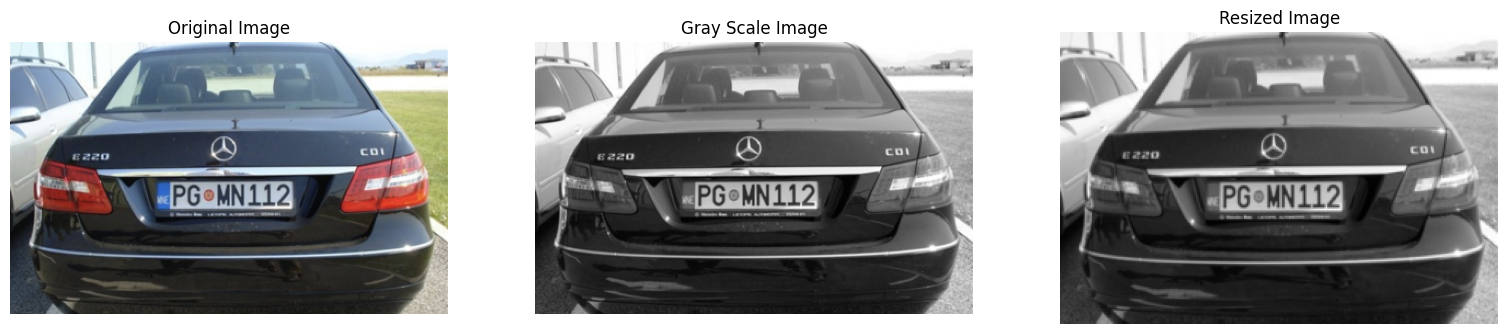

In [14]:
resized_image  = resize_with_aspect_ratio(gray_image, width = IMAGE_WIDTH, height = IMAGE_HEIGHT)
show_images([sample_image,gray_image,resized_image],['Original Image' , 'Gray Scale Image','Resized Image'])

## Convert to binary

In [15]:
# Apply adaptive thresholding
# cv2.adaptiveThreshold(): This function applies adaptive thresholding where the threshold value 
# is calculated based on the local neighborhood of each pixel. 
# It is particularly useful when the image has different lighting across different regions.

# 255 (Max Value): This is the maximum value that will be assigned to pixels 
# that exceed the dynamically calculated threshold in each region. 

# cv2.ADAPTIVE_THRESH_MEAN_C: The threshold value is the mean of the local neighborhood minus a constant C.
# cv2.ADAPTIVE_THRESH_GAUSSIAN_C: The threshold value is the weighted sum of the local neighborhood minus a constant C.

# block size of a local region
# must be odd 
def convert_to_binary(image,block_size = 31,constant = 2):
    binary_image_adaptive = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, constant
    )
    return binary_image_adaptive
    

binary_image_adaptive = convert_to_binary(resized_image)

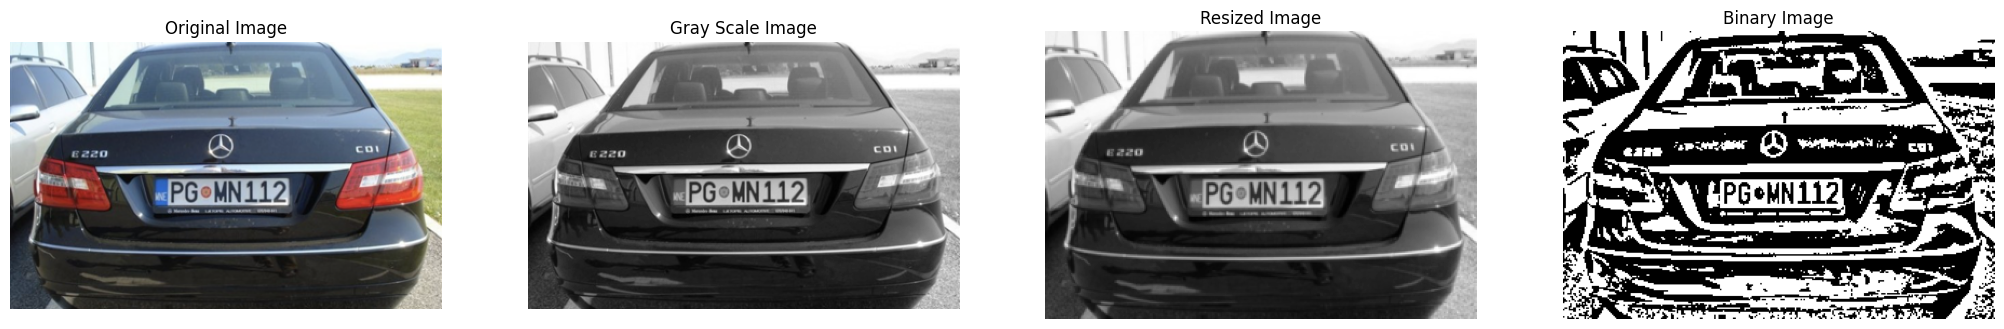

In [16]:
show_images([sample_image,gray_image,resized_image,binary_image_adaptive],
            ['Original Image' , 'Gray Scale Image','Resized Image','Binary Image'])

## Compining operations

In [17]:
def image_preprocessing(image_name, image_dir, annotation_dir,
                        resized_width = 300, resized_height = 200, 
                        keep_aspect_ratio = False,
                        resize_interpolation = cv2.INTER_AREA,
                        adaptive_threshold_block_size = 31,
                        adaptive_threshold_constant = 2,
                        load_annotation = False):
    # load image
    original_image = load_image_and_annotation(image_name,
                                               image_dir,
                                               annotation_dir,
                                               load_annotation)
    # convert to gray scale
    gray_scale_image = convert_to_gray(original_image)
    # resize image
    resized_image  = resize_with_aspect_ratio(gray_scale_image, 
                                              width = resized_width, 
                                              height = resized_height,
                                              keep_aspect_ratio = keep_aspect_ratio,
                                              interpolation = resize_interpolation)
    # convert to binary using adaptive thresholding
    binary_image_adaptive = convert_to_binary(resized_image,
                                              block_size = adaptive_threshold_block_size,
                                              constant = adaptive_threshold_constant)
    # display the results
    show_images([original_image,gray_scale_image,resized_image,binary_image_adaptive],
            ['Original Image' , 'Gray Scale Image','Resized Image','Binary Image'])
    

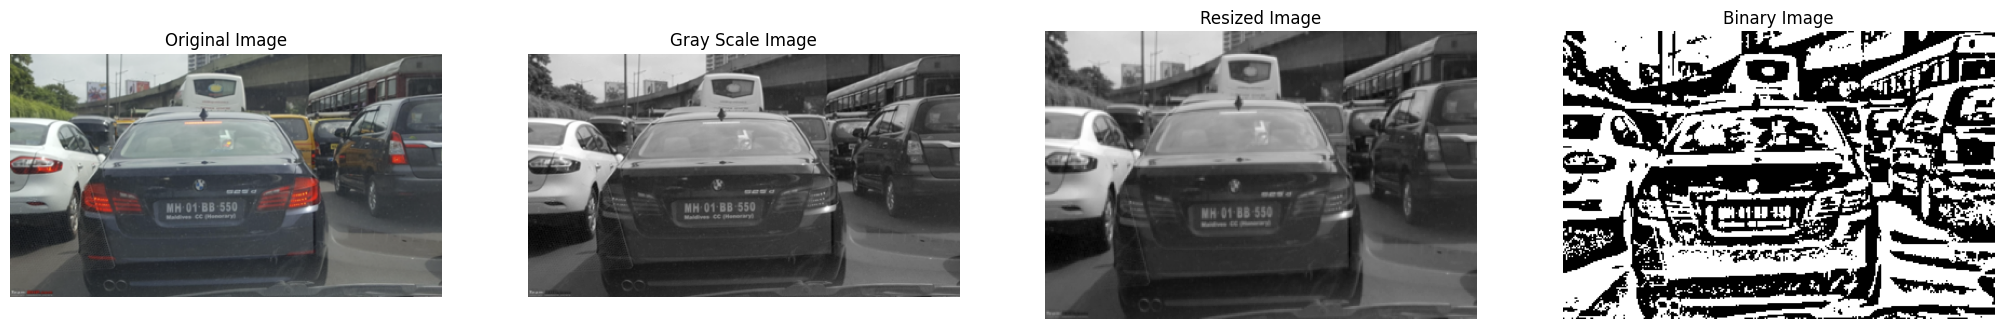

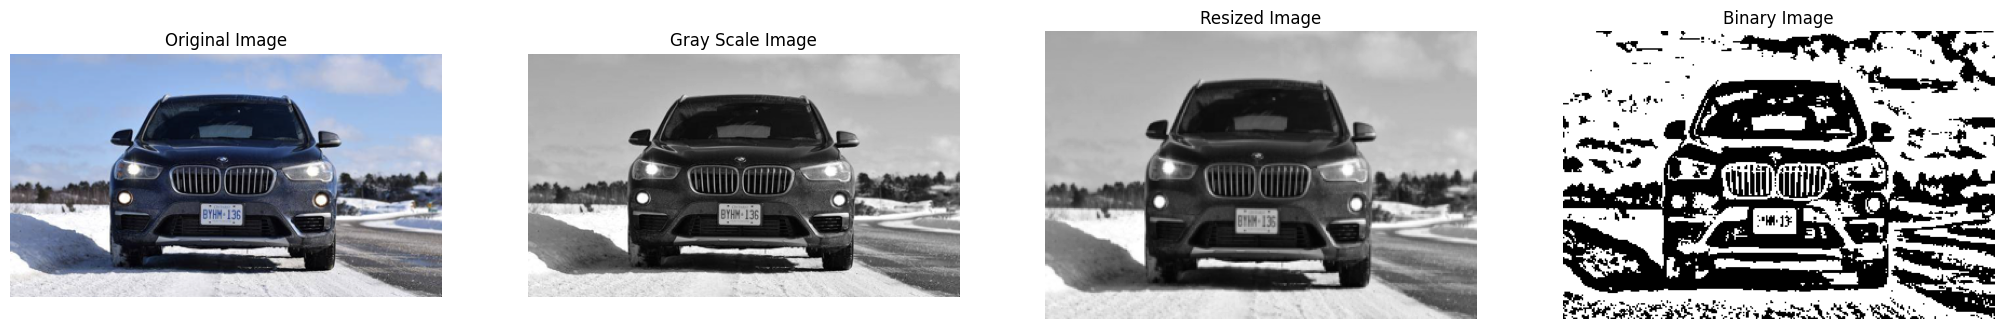

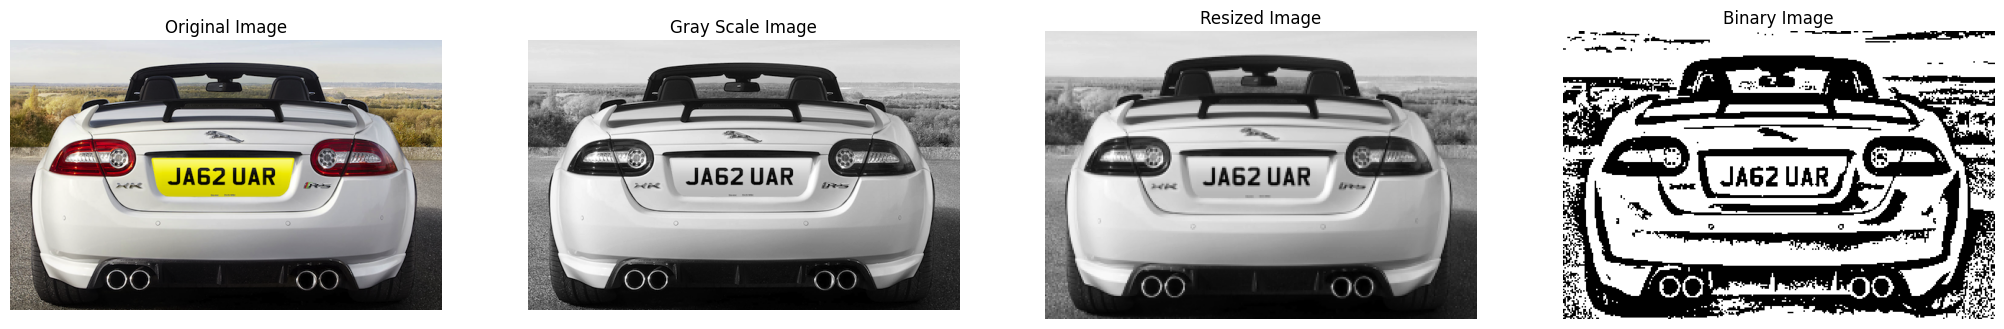

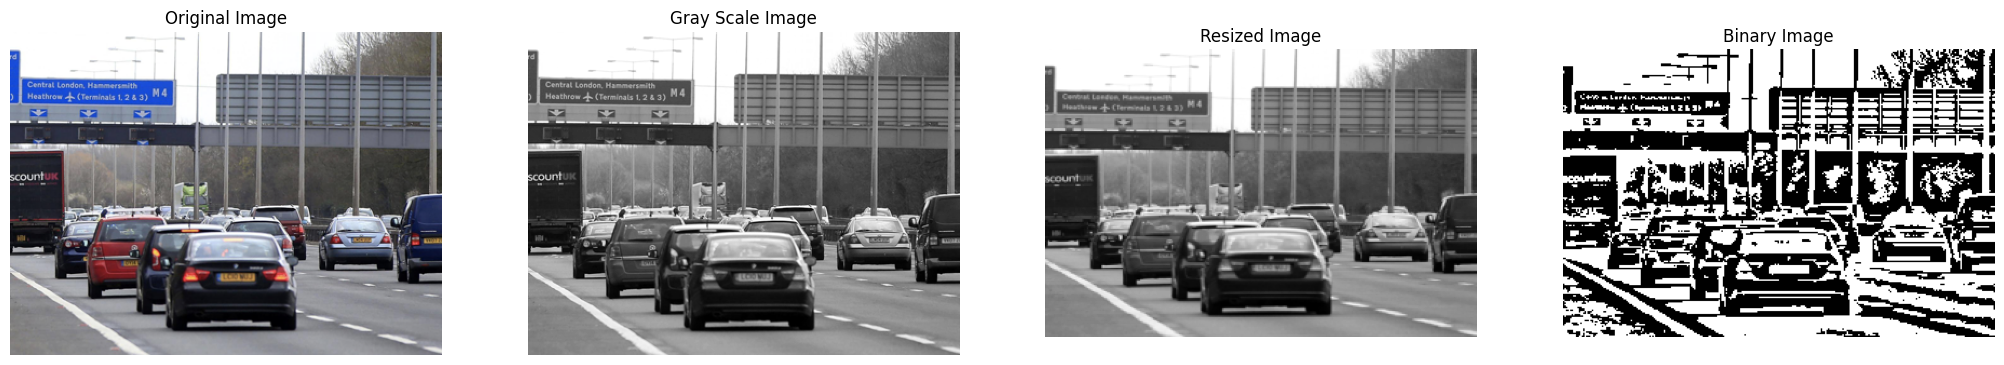

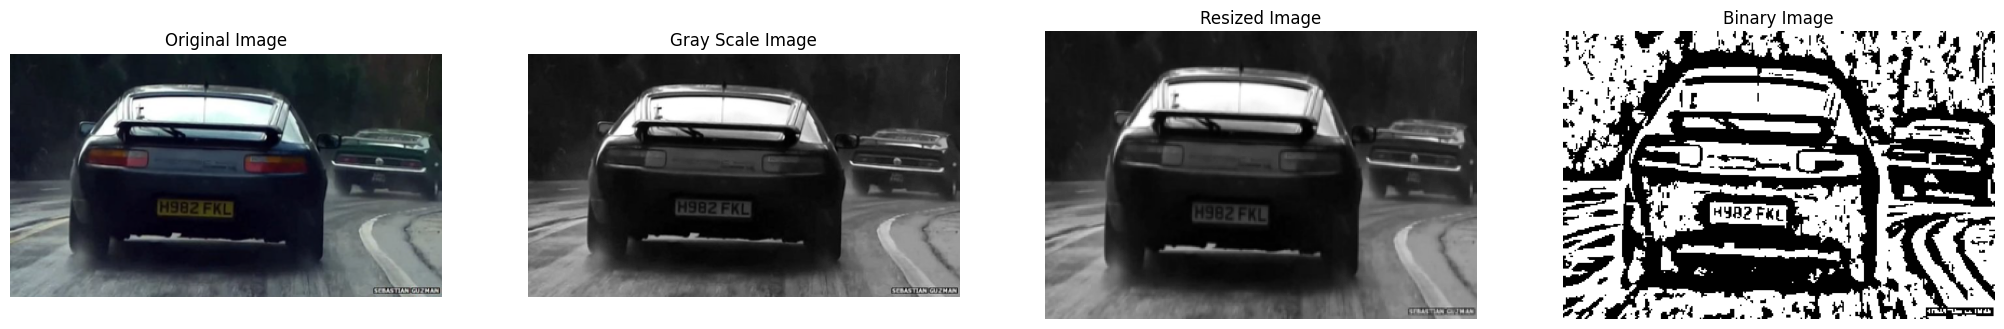

In [18]:
def preprocess_random_images(num_of_tests = 5):
    for i in range(num_of_tests):
        random_number = random.randint(0, len(image_files) - 1)
        image_preprocessing(image_name = image_files[random_number],
                            image_dir = IMAGES_DIR,
                            annotation_dir = ANNOTATIONS_DIR,
                            adaptive_threshold_block_size = 31,
                            resized_width = IMAGE_WIDTH,
                            resized_height = IMAGE_HEIGHT)    

preprocess_random_images()

# Plate Detection

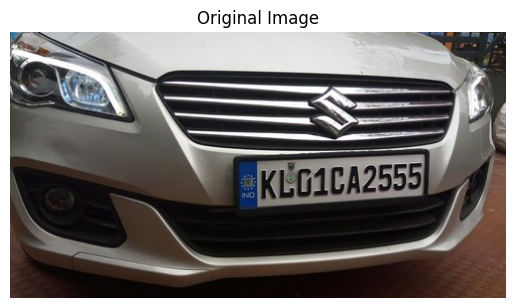

In [36]:
# load image
original_image = load_image_and_annotation(image_files[0],
                                           IMAGES_DIR,
                                           ANNOTATIONS_DIR,
                                           load_annotation = False)
show_images([original_image],
            ['Original Image'])

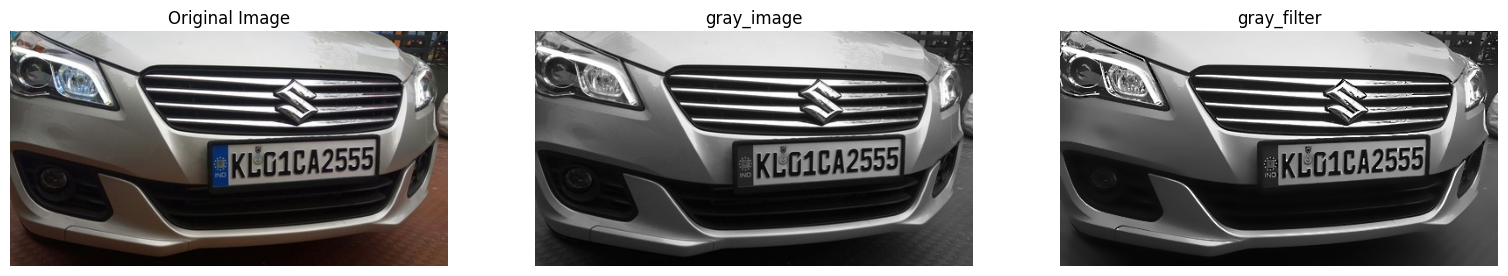

In [37]:
# convert to gray scale
gray_scale_image = convert_to_gray(original_image)
gray_filter = cv2.bilateralFilter(gray_scale_image, 13, 15, 15)

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))    # Har bir pixelga ishlov berish uchun

imgTopHat = cv2.morphologyEx(gray_filter, cv2.MORPH_TOPHAT, structuringElement)     #yorqin 
imgBlackHat = cv2.morphologyEx(gray_filter, cv2.MORPH_BLACKHAT, structuringElement)    #qora

imgGrayscalePlusTopHat = cv2.add(gray_filter, imgTopHat)           # Yorqinni qo'shamiz
gray_filter = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)     # qorani ayiramiz

show_images([original_image,gray_scale_image,gray_filter],
            ['Original Image','gray_image','gray_filter'])

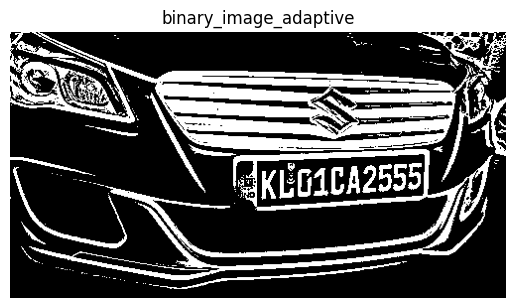

In [38]:
binary_image_adaptive = cv2.adaptiveThreshold(
                            gray_filter, 255,
                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV,
                            19, 
                            9)
show_images([binary_image_adaptive],
            ['binary_image_adaptive'])

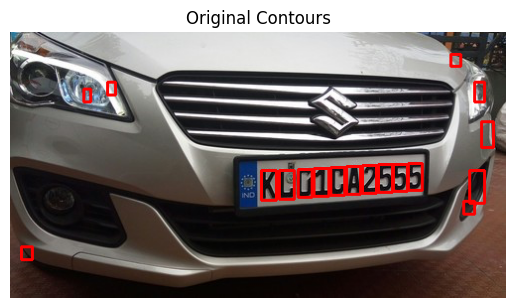

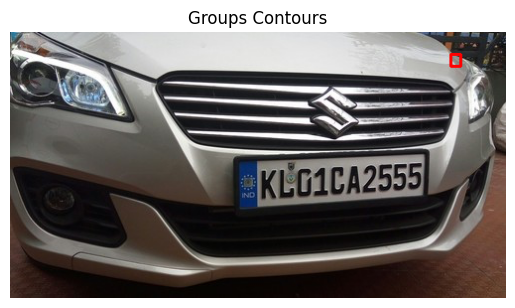

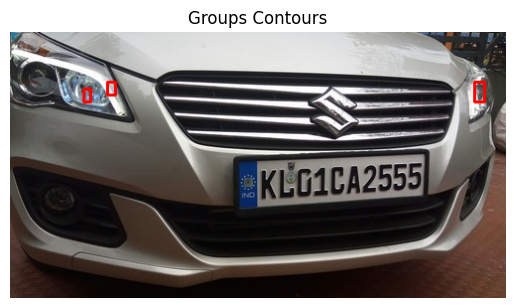

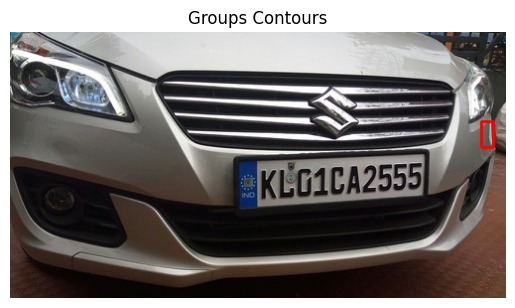

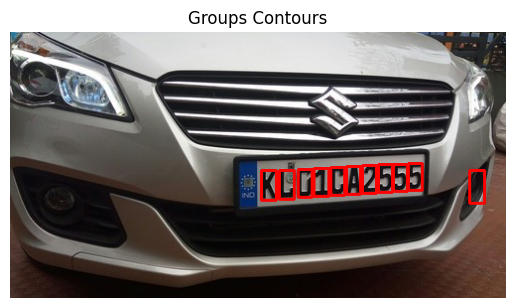

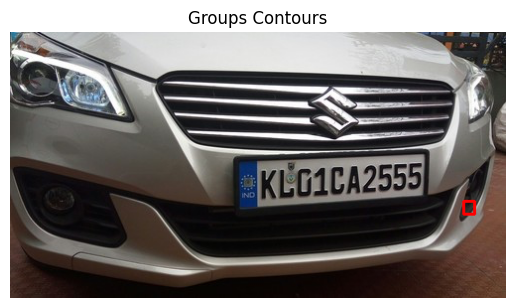

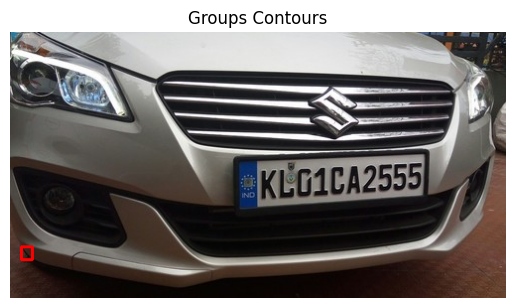

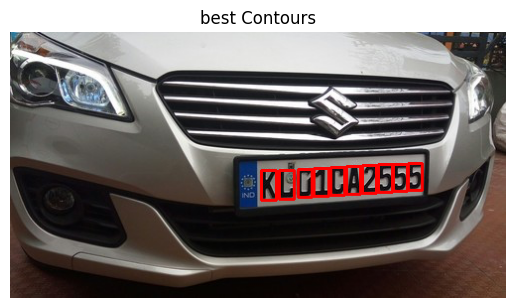

In [39]:
# If you pass cv.CHAIN_APPROX_NONE, 
# all the boundary points are stored. 
# But actually do we need all the points? 
# For eg, you found the contour of a straight line. 
# Do you need all the points on the line to represent that line? 
# No, we need just two end points of that line. 
# This is what cv.CHAIN_APPROX_SIMPLE does. 
# It removes all redundant points and compresses the contour, 
# thereby saving memory.

edged = np.uint8(binary_image_adaptive)  # Convert to uint8 type

# retrieves all of the contours without establishing any hierarchical relationships.
contours = cv2.findContours(edged.copy(),
                            cv2.RETR_LIST,
                            cv2.CHAIN_APPROX_SIMPLE)

black_screen = np.copy(original_image)

contours = imutils.grab_contours(contours)
contours = sorted(contours,key=cv2.contourArea, reverse = True)
screenCnt = None


x_similarity_threshold = 10 # the thershold in x-axis to say that two contours have the same x coordinate
y_similarity_threshold = 10 # the thershold in y-axis to say that two contours have the same x coordinate

best_contours = []
plate_numbers = []
for contour in contours:
    # bounding rectangle returns the x,y of the top left corner and the width and height of the rect.
    x, y, w, h = cv2.boundingRect(contour)
    
    # Apply size and aspect ratio filters
    if w * h > 30 and 4 > h / w > 1 and w * h < 1500 and h > 10:
        is_duplicate = False
        
        for existing_x, existing_y, _, _ in best_contours:
            if (abs(x - existing_x) < x_similarity_threshold and
                abs(y - existing_y) < y_similarity_threshold):
                is_duplicate = True
                break
        
        if not is_duplicate:
            best_contours.append([x, y, w, h])
            cv2.rectangle(black_screen, (x, y), (x + w, y + h), (255, 0, 0), 2)


show_images([black_screen], ['Original Contours'])

def get_y_coordinate(contour):
    _, y, _, _ = contour
    return y

def get_x_coordinate(contour):
    x, _, _, _ = contour
    return x


#---------------------------------Divide the contours to groups based on y axis level--------------------------------

# Sort the contours based on the y-coordinate
sorted_contours = sorted(best_contours, key=get_y_coordinate)

contours_group = [[]]
group_idx = 0
vertical_threshold = 15 # define the maximum vertical difference between two contours
horizontal_threshold = 30  # define the maximum horizontal difference between two contours

for i in range(len(sorted_contours)):
    if len(contours_group[group_idx]) == 0:
        contours_group[group_idx].append(sorted_contours[i])
        continue
        
    current_contour = sorted_contours[i]
    first_contour = contours_group[group_idx][0]
    
    current_y = current_contour[1]
    first_y = first_contour[1]
    
    vertical_check = current_y < first_y + vertical_threshold
    
    if vertical_check:
        contours_group[group_idx].append(sorted_contours[i])
    else:
        group_idx += 1
        contours_group.append([sorted_contours[i]])

#---------------------------------Display the groups--------------------------------
for group in contours_group:
    black_screen = np.copy(original_image)
    for rect in group:
        x,y,w,h = rect
        cv2.rectangle(black_screen, (x, y), (x+w, y+h), (255, 0, 0), 2)  
    show_images([black_screen], ['Groups Contours'])  

# Function to get the contours with common area as the plate numbers will be propably with the same area for the same car 
# so we can remove other contours which they will be not relevant

def get_common_contours(groups):
    tolerance = 50
    
    for i in range(len(groups)):
        group = groups[i]
        
        areas = [ w * h for _, _, w, h in group]
        
        # Determine the median area
        median_area = np.median(areas)
        
        # Define tolerance range based on MAD
        lower_bound = median_area - median_area * (tolerance/100)
        upper_bound = median_area + median_area * (tolerance/100)
        # Filter contours based on area similarity
        filtered_group = []
        for contour in group:
            area =  contour[2] * contour[3]
            if lower_bound <= area <= upper_bound:
                filtered_group.append(contour)
            
        
        # Update the group with filtered contours
        groups[i] = filtered_group
        
    return groups   

def get_common_contours_height(groups):
    tolerance = 20
    
    for i in range(len(groups)):
        group = groups[i]
        
        height = [ h for _, _, w, h in group]
        
        # Determine the median area
        median_height = np.median(height)
        

        lower_bound = median_height - median_height * (tolerance/100)
        upper_bound = median_height + median_height * (tolerance/100)

        filtered_group = []
        for contour in group:
            height =  contour[3]
            if lower_bound <= height <= upper_bound:
                filtered_group.append(contour)
            
        
        # Update the group with filtered contours
        groups[i] = filtered_group
        
    return groups 
#---------------------------------Divide the contours to groups based on x axis level--------------------------------

horizontal_groups = []
best_groups = []
overlap_thershold = 10
def get_horizontal_groups(sorted_horizontal_contours):
    groups = [[]]
    group_idx = 0
    for i in range(len(sorted_horizontal_contours)):
        
        if len(groups[group_idx]) == 0:
            groups[group_idx].append(sorted_horizontal_contours[i])
            continue
            
        current_x,_,current_w,_ = sorted_horizontal_contours[i]
        last_x,_,last_w, _ = groups[group_idx][-1]    

        right_horizontal_check = (current_x < last_x + last_w + horizontal_threshold and 
                                 current_x  >  last_x + last_w - overlap_thershold)
        
        if right_horizontal_check == True:
            groups[group_idx].append(sorted_horizontal_contours[i])
        else:
            group_idx += 1
            groups.append([sorted_horizontal_contours[i]])
    return groups


for group in contours_group:
    if len(group) < 4:
        continue
    
    sorted_group = sorted(group, key=get_x_coordinate)
    horizontal_groups = horizontal_groups + get_horizontal_groups(sorted_group)   

horizontal_groups = get_common_contours_height(horizontal_groups)   
#---------------------------------Grab the sequences lager than 4 contours--------------------------------
for group in horizontal_groups:
    if len(group) < 4:
        continue
    best_groups.append(group)
    black_screen = np.copy(original_image)
    for rect in group:
        x,y,w,h = rect
        cv2.rectangle(black_screen, (x, y), (x+w, y+h), (255, 0, 0), 2)  
    show_images([black_screen], ['best Contours'])      

In [40]:
chars = []
def get_chars_from_contours(contour,image):
    x,y,w,h = contour
    char = image[y:y+h,x:x+w]
    char = cv2.resize(char,(28,28))
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    char = cv2.dilate(char, structuringElement, iterations=1)

    imgTopHat = cv2.morphologyEx(char, cv2.MORPH_TOPHAT, structuringElement)     #yorqin 
    imgBlackHat = cv2.morphologyEx(char, cv2.MORPH_BLACKHAT, structuringElement)    #qora
    
    imgGrayscalePlusTopHat = cv2.add(char, imgTopHat)           # Yorqinni qo'shamiz
    char = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    char = cv2.adaptiveThreshold(
                            char, 255,
                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV,
                            31, 
                            5)
    show_images([char])
    chars.append(char)

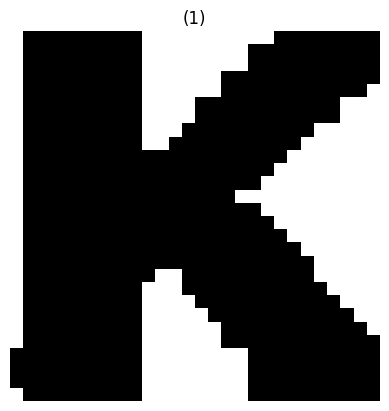

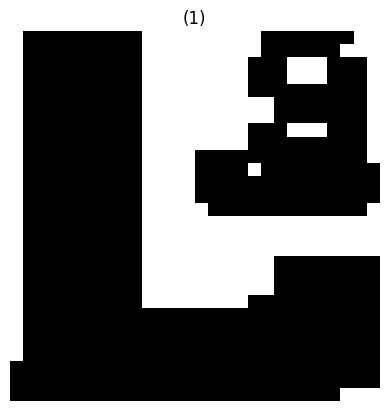

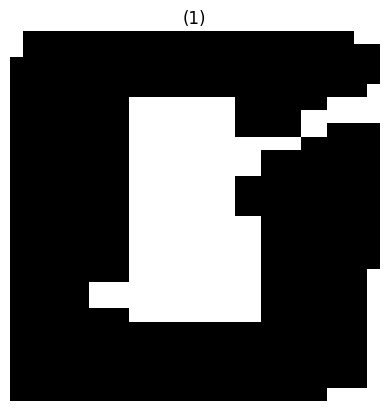

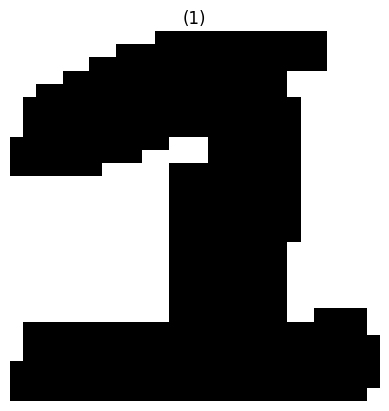

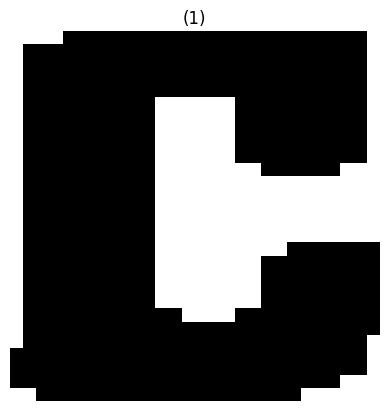

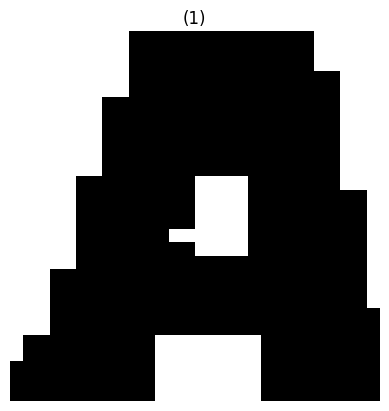

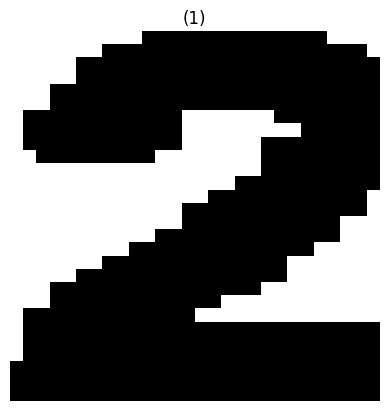

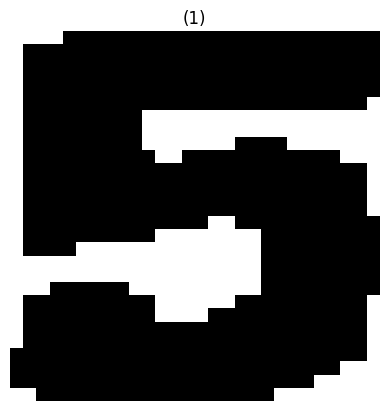

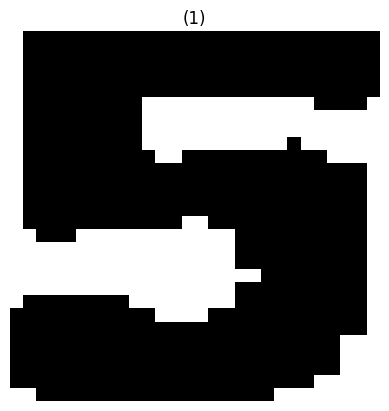

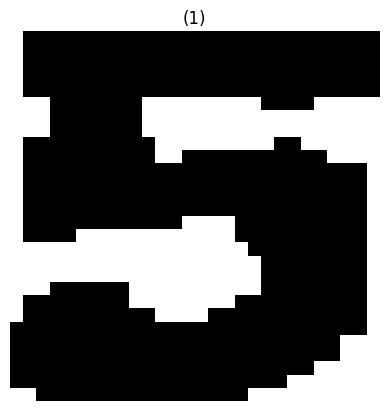

In [41]:
for group in best_groups:
    for contour in group:
        get_chars_from_contours(contour,binary_image_adaptive)